WRITE A DESCRIPTION

In [337]:
#! pip install simpy
#import simpy
#! pip install numpy
#import numpy as np
#! pip install seaborn
#import seaborn as sns
#import matplotlib.pyplot as plt
#import pandas as pd
#import random
#from IPython.display import display

In [338]:
class Scheduler:

    def __init__(self, environment, type):

        self.environment = environment
        self.type = type
        self.pending_tasks = []
        self.incomplete_tasks= []
        self.completed_tasks = []
        self.task_id_counter = 0
        self.current_task = None
        
        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))
        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))
        else:
            print("Incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def process_randomly(self, environment):
        while True:
            if self.pending_tasks:
                next_task = random.choice(self.pending_tasks)
                yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1)

    def process_fifo(self, environment):
         while True:
            if self.pending_tasks:
                 next_task = self.pending_tasks[0]
                 yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:
            if self.pending_tasks:
                next_task = self.pending_tasks.pop()
                yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1) 

    def process_edf(self, environment):

        current_task_process = None
        next_task_process = None
        highest_priority_task = None
        
        while True:
            
            if self.pending_tasks:
                
                #for the first task 
                if(self.current_task == None):
                    self.current_task = min(self.pending_tasks, key = lambda x: x.priority)
                    current_task_process = environment.process(self.current_task.process(environment.now))

                highest_priority_task = min(self.pending_tasks, key = lambda x: x.priority)
                
                if self.current_task != highest_priority_task and self.current_task.priority > highest_priority_task.priority:
                    print(f"Scheduler: Interrupting Task {self.current_task.id} for Task {highest_priority_task.id} at {environment.now}")
                    current_task_process.interrupt(simpy.Interrupt(current_task_process))
                    print(f"Scheduler: Task {self.current_task.id} has been interrupted")
                    self.current_task = highest_priority_task
                    current_task_process = environment.process(self.current_task.process(environment.now))
                
                #print(f"incrementing time from {environment.now} to {environment.now + 1}")

                yield environment.timeout(1)
                if(self.current_task == None):
                    self.current_task = min(self.pending_tasks, key = lambda x: x.priority)
                    current_task_process = environment.process(self.current_task.process(environment.now))
            else:
                yield environment.timeout(1)
            
  #  def process_oracle():

In [339]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment

        self.time_spent_processing = 0
        self.start = None 
        self.vehicle.assigned_tasks.append(self)
        self.vehicle.scheduler.task_id_counter += 1
        self.vehicle.scheduler.pending_tasks.append(self)

        print(f"Task {self.id} came into existance at {self.environment.now}")

    def process(self, start):
        try:
            self.start = start
            print(f'Task {self.id} started processing at {self.start}')
            if self not in self.vehicle.scheduler.incomplete_tasks:
                self.vehicle.scheduler.incomplete_tasks.append(self)
            if self in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.remove(self)
            
            #try to timeout for the time needed to complete the task
            yield self.environment.timeout(self.duration - self.time_spent_processing) 
            print(f'Task {self.id} completed at {self.environment.now}')
            self.vehicle.scheduler.current_task = None
            
            self.vehicle.completed_tasks.append(self)   #or do this with scheduler processed tasks
            self.vehicle.scheduler.incomplete_tasks.remove(self)
            if self not in self.vehicle.scheduler.completed_tasks:
                self.vehicle.scheduler.completed_tasks.append(self)

        except simpy.Interrupt:
            usage = self.environment.now - self.start 
            #save the processing progress of the task
            self.time_spent_processing += usage
            if self not in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.append(self)

            print(f'Task {self.id} got preempted at {self.environment.now} after running for {usage}')

In [340]:
class Vehicle:

    def __init__(self, id, environment, assigned_tasks, lambda_tasks, lambda_dwell_time, scheduler, generator):

        self.id = id
        self.environment = environment
        self.assigned_tasks = assigned_tasks
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time   
        self.scheduler = scheduler
        self.generator = generator

        self.completed_tasks = []
        self.inROI = True

        print(f'Vehicle {self.id} spawned in environment at time {self.environment.now}')
        self.generator.vehicles.append(self)
        self.generator.vehicles_present.append(self)

        #start lifecycle of every task that is created before simulation
        for task in assigned_tasks:     
            self.scheduler.task_id_counter += 1          
            self.scheduler.pending_tasks.append(task)

        #schedule departure
        #self.environment.process(self.scheduleDeparture(self.environment))
        #start task generator
       # self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def generateTasks(self):

        while self.inROI:

            priority = random.randint(0, 5)
            duration = random.randint(1, 5)
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            new_Task = Task(self.scheduler.task_id_counter, priority, duration, self, self.environment)
            print(f'Vehicle {self.id} generated a new Task at {self.environment.now} - new Task id:{new_Task.id}, priority: {new_Task.priority} and duration: {new_Task.duration}')
           
        self.generator.vehicles_present.remove(self)
        self.generator.vehicles_departed.append(self)

        print(f"Vehicle {self.id} left the intersection at {self.environment.now} and has stopped generating tasks ")

In [341]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler, generate):

        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler
        self.generate = generate

        self.vehicles = []
        self.vehicles_present = []
        self.vehicles_departed = []

        if self.generate:
            self.environment.process(self.generateVehicles(self.environment))
    
    def tasks_generated(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.assigned_tasks)
        return counter
    
    def mean_tasks_completed_per_vehicle(self):
        sum = 0
        if len(self.vehicles) == 0: return 0

        for v in self.vehicles:      
           # if len(v.assigned_tasks) != 0:
            print(f"vehicle id: {v.id}, completed tasks: {len(v.completed_tasks)}")
            sum += len(v.completed_tasks)#/len(v.assigned_tasks)

        mean = (sum/len(self.vehicles))
        return mean
    
    def time_spent_processing(self):
        result = []

        for v in self.vehicles:
            v_processing_time = 0
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.completed_tasks]
            #processing time of all completed tasks
            for t in v.completed_tasks:
                v_processing_time += t.duration
            #processing time of all incomplete tasks
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing if t.time_spent_processing != 0 else (self.environment.now - t.start if t.start != None else 0)
            result.append(v_processing_time)    
                
        #should hold the time spent processing for each vehicle   
        return result 
    
    def scheduling_type(self):
        result = []
        for v in self.vehicles:
            result.append(v.scheduler.type)
        return result
        
    def generateVehicles(self, environment):
        while True:
            timeout = np.random.poisson(self.lambda_vehicles)
            yield environment.timeout(timeout)
            Vehicle(len(self.vehicles), environment, [], self.lambda_tasks, self.lambda_dwell_time, self.scheduler, self)

In [342]:
simulation_data = pd.DataFrame(columns=['scheduling type', 'total vehicles generated',
                                        'vehicles present', 'vehicles departed',
                                        'total tasks generated', 'total tasks completed', 
                                        'total tasks completed percentage', 
                                        'avg. tasks completed per vehicle', 'incomplete tasks',
                                        'vehicle processing times', 'mean vehicle processing times'
                                        ])
exploded_data = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time, generate):

   global simulation_data
   global exploded_data
   index = 0
   
   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
        
      #run simulation
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, type)
      #inactive in this case 
      vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler, generate)
      print(f"{'='*50}\nSCHEDULER: {scheduler.type}")
      
      # own case here
      #two vehicles two tasks
      v0 = Vehicle(id=0, environment= intersection, assigned_tasks= [], lambda_tasks= None, lambda_dwell_time= None, scheduler= scheduler, generator= vehicle_generator )
      v1 = Vehicle(id=1, environment= intersection, assigned_tasks= [], lambda_tasks= None, lambda_dwell_time= None, scheduler= scheduler, generator= vehicle_generator )
      v2 = Vehicle(id=2, environment= intersection, assigned_tasks= [], lambda_tasks= None, lambda_dwell_time= None, scheduler= scheduler, generator= vehicle_generator )
      #v3 = Vehicle(id=3, environment= intersection, assigned_tasks= [], lambda_tasks= None, lambda_dwell_time= None, scheduler= scheduler, generator= vehicle_generator )
      
      t0 = Task(id = 0, priority = 3, duration= 1, vehicle= v0, environment=intersection)
      t1 = Task(id = 1, priority = 0, duration= 3, vehicle= v1, environment=intersection)
      t2 = Task(id = 2, priority = 0, duration= 5, vehicle= v1, environment=intersection)
      t3 = Task(id = 3, priority = 3, duration= 8, vehicle= v2, environment=intersection)


      intersection.run(until = sim_end_time)

      print(f"simulation ended at {intersection.now}\n{'='*50}\n total vehicles spawned: {len(vehicle_generator.vehicles)}\n total tasks generated: {vehicle_generator.tasks_generated()}")

      simulation_data.loc[index] = [type,                                                                                                                                  #scheduling type  
                                    len(vehicle_generator.vehicles),                                                                                                       #total vehicles generated
                                    len(vehicle_generator.vehicles_present),                                                                                               #vehicles present
                                    len(vehicle_generator.vehicles_departed),                                                                                              #vehicles departed
                                    vehicle_generator.tasks_generated(),                                                                                                   #total tasks generated  
                                    len(scheduler.completed_tasks),                                                                                                        #total tasks completed',
                                    len(scheduler.completed_tasks)/vehicle_generator.tasks_generated() * 100 if vehicle_generator.tasks_generated() != 0 else 0,           #total tasks completed percentage
                                    vehicle_generator.mean_tasks_completed_per_vehicle(),                                                                                  #avg. tasks completed per vehicle
                                    len(scheduler.incomplete_tasks),                                                                                                       #incomplete tasks
                                    vehicle_generator.time_spent_processing(),                                                                                             #vehicle processing times
                                    0 if len(vehicle_generator.vehicles) == 0 else round(sum(vehicle_generator.time_spent_processing())/len(vehicle_generator.vehicles),1) #mean vehicle processing times
                                    ]
      index += 1
      
   #dataframe for swarmplot
   exploded_data = simulation_data.explode('vehicle processing times').reset_index(drop=True)[['scheduling type', 'vehicle processing times']]

In [343]:
run_sim(sim_seed = 42, scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF'], poisson_vehicles = 3, poisson_tasks = 5, poisson_dwell_time = 15, sim_end_time = 10, generate = False)

SCHEDULER: RANDOM
Vehicle 0 spawned in environment at time 0
Vehicle 1 spawned in environment at time 0
Vehicle 2 spawned in environment at time 0
Task 0 came into existance at 0
Task 1 came into existance at 0
Task 2 came into existance at 0
Task 3 came into existance at 0
Task 0 started processing at 0
Task 0 completed at 1
Task 1 started processing at 1
Task 1 completed at 4
Task 3 started processing at 4
simulation ended at 10
 total vehicles spawned: 3
 total tasks generated: 4
vehicle id: 0, completed tasks: 1
vehicle id: 1, completed tasks: 1
vehicle id: 2, completed tasks: 0
SCHEDULER: FIFO
Vehicle 0 spawned in environment at time 0
Vehicle 1 spawned in environment at time 0
Vehicle 2 spawned in environment at time 0
Task 0 came into existance at 0
Task 1 came into existance at 0
Task 2 came into existance at 0
Task 3 came into existance at 0
Task 0 started processing at 0
Task 0 completed at 1
Task 1 started processing at 1
Task 1 completed at 4
Task 2 started processing at 4


,scheduling type,total vehicles generated,vehicles present,vehicles departed,total tasks generated,total tasks completed,total tasks completed percentage,avg. tasks completed per vehicle,incomplete tasks,vehicle processing times,mean vehicle processing times
0,RANDOM,3,3,0,4,2,50.0,0.666667,1,"[1, 3, 6]",3.3
1,FIFO,3,3,0,4,3,75.0,1.000000,1,"[1, 8, 1]",3.3
2,LIFO,3,3,0,4,1,25.0,0.333333,1,"[0, 2, 8]",3.3
3,EDF,3,3,0,4,3,75.0,1.000000,0,"[1, 8, 0]",3.0


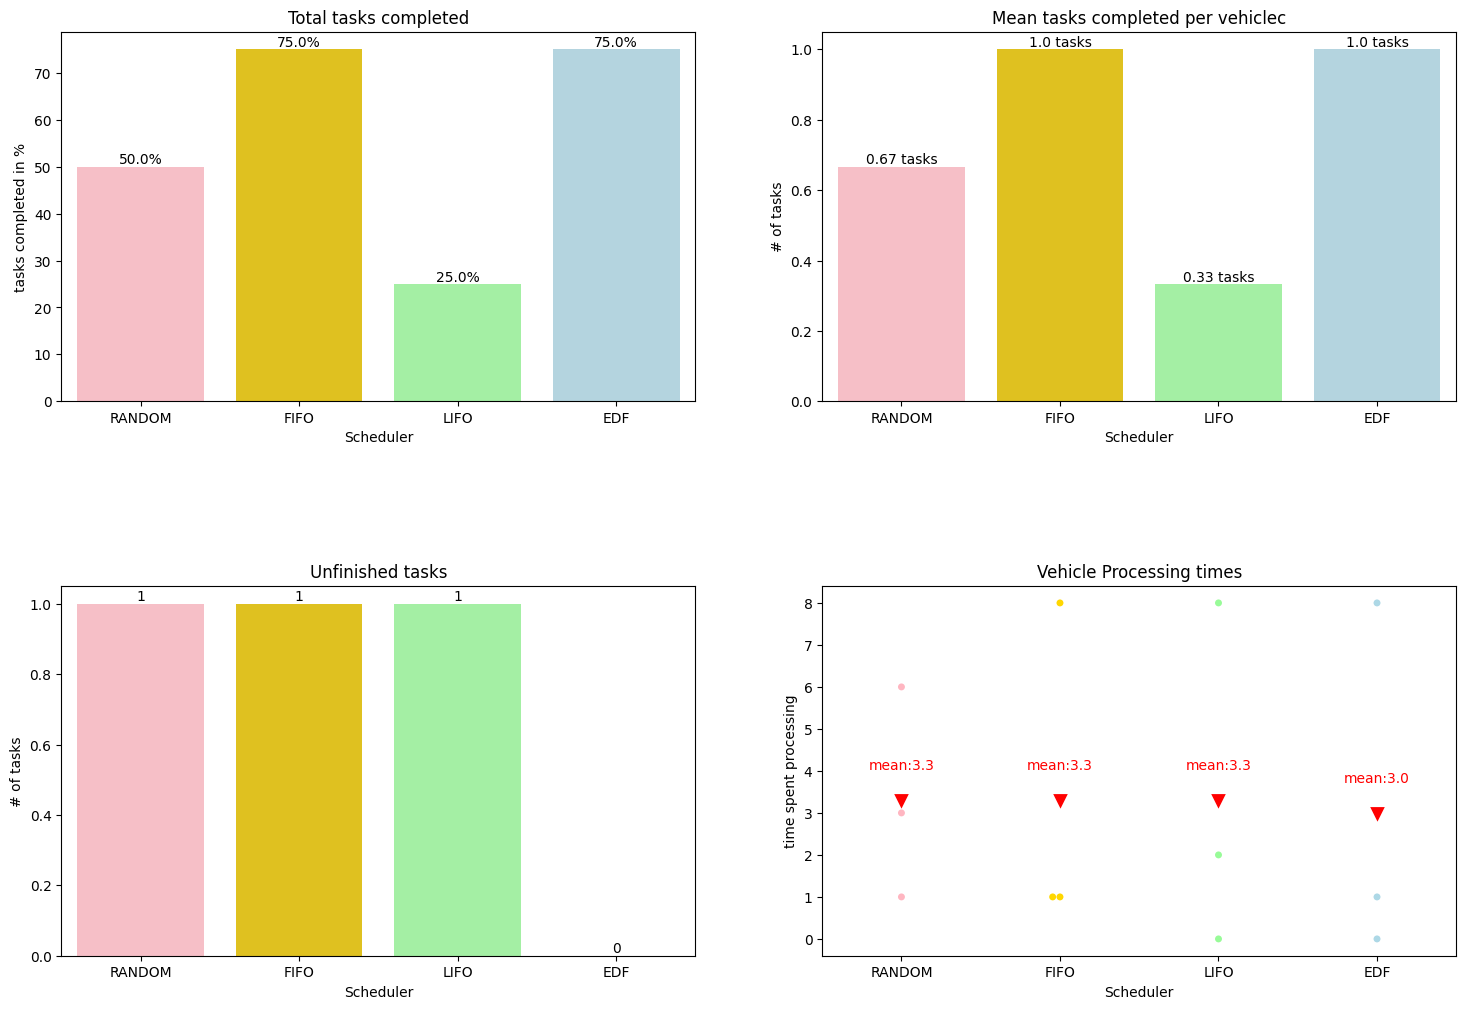

In [344]:
scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF']

pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)


# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue= scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Total tasks completed')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')

# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue= scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('Mean tasks completed per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('# of tasks')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['incomplete tasks'], ax=axes[1, 0], hue= scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Unfinished tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('# of tasks')

# plot 4
sns.swarmplot(data=exploded_data, x='scheduling type', y='vehicle processing times', ax=axes[1, 1], hue= exploded_data['scheduling type'], palette=pastel_colors)
axes[1,1].set_title('Vehicle Processing times')
axes[1,1].set_xlabel('Scheduler')
axes[1,1].set_ylabel('time spent processing')

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value,f"{round(value,2)} tasks", ha='center', va='bottom')

for index, value in enumerate(simulation_data['incomplete tasks']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

sns.pointplot(data= simulation_data, x='scheduling type', y='mean vehicle processing times', color='red', markers='v', linestyle='none')

for i, row in simulation_data.iterrows():
    plt.text(i, row['mean vehicle processing times'] + 1, f'mean:{row["mean vehicle processing times"]:.1f}', color='red', ha="center", va = "top")
    
display(simulation_data)
plt.show()